# **Save this file as studentid1_studentid2_lab2.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [67]:
NAME = ""
NAME2 = ""
NAME3 = ""
EMAIL = ""
EMAIL2 = ""
EMAIL3 = ""

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [68]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


/home/stijnverdenius/miniconda3/envs/ml1labs/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'indices', 'logistic', 'maximum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [69]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [70]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

/home/stijnverdenius/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/stijnverdenius/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

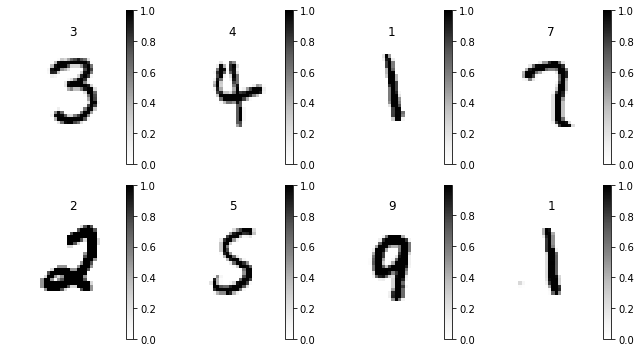

In [71]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= \frac{\partial \mathcal\log q_j}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1  - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



$$
\frac{\partial Z}{\partial \log q_j}
=
\frac{\partial (\sum_i \exp(\log q_i))}{\partial \log q_j}
=
\frac{\partial (\exp(\log q_1) + \exp(\log q_2) + \exp(\log q_3) + ... )}{\partial \log q_j}
=
\frac{\partial (0 + \exp(\log q_j) + 0)}{\partial \log q_j}
=
\exp(\log q_j)
$$

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
=
1  - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 
1 - \frac{\exp(\log q_j)}{Z} 
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
=
- \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
=
- \frac{1}{Z} 
\frac{\partial Z}{\partial \log q_j}
&=
- \frac{\exp(\log q_j)}{Z} 
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$
\bw_j^T
=
\begin{bmatrix}
w_1j & w_2j & w_3j & ... & w_{784}j
\end{bmatrix}
$
so
$
\frac{\partial\bw_j^T}{\partial W_{ij}}
=
\begin{bmatrix}
0 & ... & 1  & ... & 0
\end{bmatrix}
$
Where the 1 is positioned at ith entry of the vector.

$
\frac{\partial (\bw_j^T \bx)}{\partial W_{ij}}
=
\frac{\partial\bw_j^T}{\partial W_{ij}}\bx
+
\bw_j^T
\frac{\partial\bx}{\partial W_{ij}}
=
\frac{\partial\bw_j^T}{\partial W_{ij}}\bx
+
\mathbf{0}
=
x_i
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial (\bw_j^T \bx + b_j)}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial (\bw_j^T \bx)}{\partial W_{ij}}
+
\frac{\partial (b_j)}{\partial W_{ij}}
=
\mathbf{\delta}_j^q
x_i
+
0
=
\mathbf{\delta}_j^q
x_i
$

$$ \frac{\partial \log q_j}{\partial W_{ij}}=\frac{\partial \mathcal{L}^{(n)}}{\partial \textbf{w}_j}= \delta^q_j\textbf{x}$$  

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [81]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    log_q = np.dot(x,w)+b
    
    # Keeping it numerically stable
    a = np.ndarray.max(log_q)
    log_Z = a
    
    log_Z += np.log(sum(np.exp(log_q-a)))
    
#     Z = np.sum(np.exp(log_q))
    
    # logp
    logp = log_q-log_Z
    
    delta_q = np.array([-np.exp(log_q[0,i])/np.exp(log_Z) for i in range(len(b))])
    delta_q[t] = 1 - np.exp(log_q[0,t])/np.exp(log_Z)
    
    dL_db = delta_q
    
    dL_dw = np.dot(x.T,delta_q.reshape(1,10))
    
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [82]:
# Hidden tests for efficiency

In [83]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [84]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.411502514845462e-07
Finite difference error grad_b: 5.235117487425521e-08


In [85]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [86]:
def sgd_iter(x_train, t_train, W, b):
    # YOUR CODE HERE
    eta = 1e-4
    indices = np.array(range(len(x_train)))
    np.random.shuffle(indices)
    
    logp_list = []
    for index in indices:
        logp_train, grad_w, grad_b = logreg_gradient(x_train[index:index+1,:], t_train[index:index+1], W, b)
        W = W + np.dot(eta, grad_w)
        b = b + np.dot(eta, grad_b)
        logp_list.append(logp_train)
        
    logp_list = []
    for index in indices:
        logp_train, grad_w, grad_b = logreg_gradient(x_train[index:index+1,:], t_train[index:index+1], W, b)
        logp_list.append(logp_train)
        
    return np.mean(logp_list), W, b

In [87]:
# Hidden tests for efficiency

In [88]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

9.223372036854776e+18 -0.7937849095101889 -0.7980809550026983
0.1898748435894878 -0.6039100659207011 -0.6116841883090679
0.07697260865774369 -0.5269374572629574 -0.5366333342573153
0.04359407794791248 -0.4833433793150449 -0.4939812922056658
0.028671807252252268 -0.45467157206279263 -0.46617746578830155
0.020779421577694246 -0.4338921504850984 -0.44593937040124254
0.015695348113183627 -0.41819680237191476 -0.43079858226807227
0.01269415862739931 -0.40550264374451545 -0.4183995901683776
0.010360375242456421 -0.395142268502059 -0.4085974793613698
0.00864910323450635 -0.3864931652675527 -0.40018637318701333
0.0075023728715094 -0.3789907923960433 -0.39290146250897523
0.006433358529864486 -0.3725574338661788 -0.3868486119054583
0.005732780319797792 -0.366824653546381 -0.38139357584190886
0.005074290322087505 -0.3617503632242935 -0.3765531337332095
0.00444367810586177 -0.3573066851184317 -0.37225305665695996
0.004129539112497582 -0.35317714600593414 -0.3684071339491193
0.003750788724956322 -0

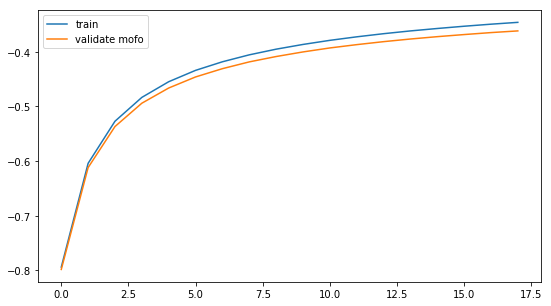

In [89]:
import sys 

def validate(x_valid, t_valid, w, b, top=0):
    
    indices = np.array(range(len(x_valid)))    
    logp_list = []
    for index in indices:
        logp_train, _, _ = logreg_gradient(x_valid[index:index+1,:], t_valid[index:index+1], w, b)
        logp_list.append(logp_train)
        
    
    maxx = np.array(logp_list).argsort()
    
    if top>=0:
        show = x_valid[maxx[len(maxx)-1-top:]]
    else:
        show = x_valid[maxx[0:-top]]

    return np.mean(logp_list), show


def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    # YOUR CODE HERE
    epsilon = 1e-12
    diff = sys.maxsize
    diff_valid = sys.maxsize
    logp = [diff]
    logp_v = [diff_valid]
    while diff > 0.0035:
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        logp_valid, _ = validate(x_valid, t_valid, w, b)
        
        diff = abs(sum(logp_train - logp[-1]))
        
        logp.append(logp_train)
        logp_v.append(logp_valid)
        
        print(diff,logp_train,logp_valid )
        
    
    logp.pop(0)
    logp_v.pop(0)
    
    plt.plot(logp, label="train")
    plt.plot(logp_v, label="validate mofo")
    plt.legend()
    plt.show()
    
    return w,b

np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [91]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


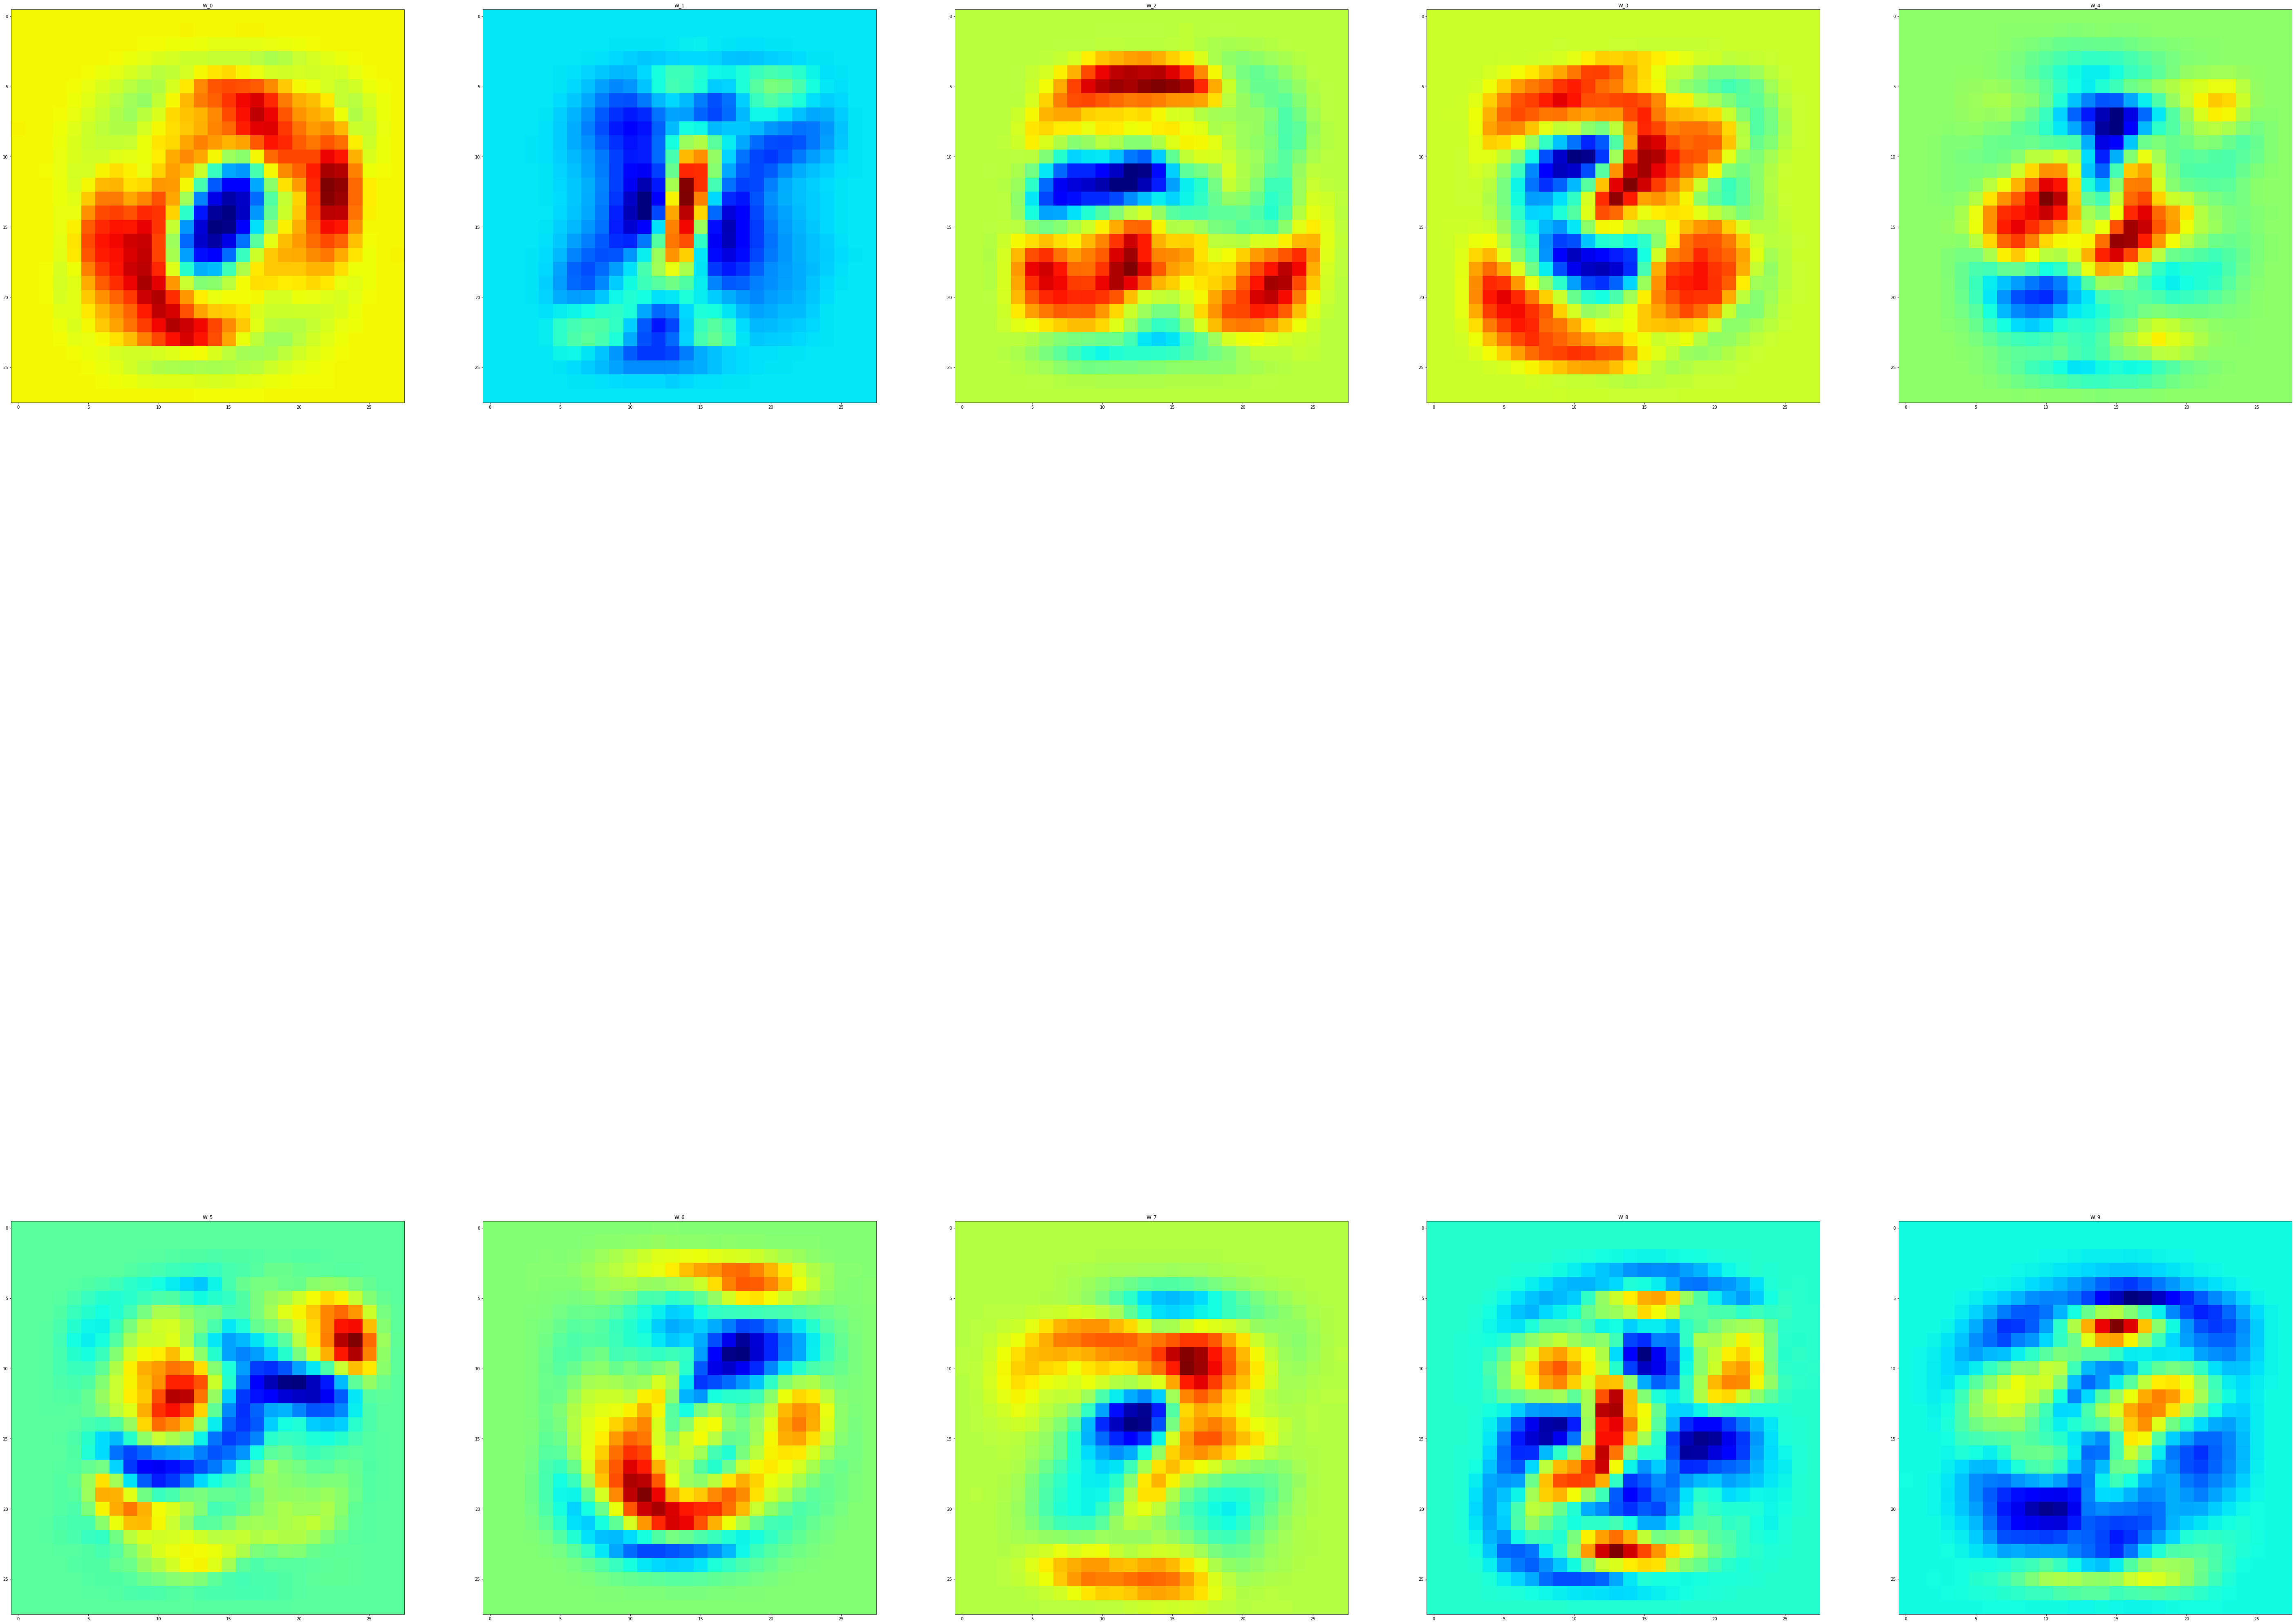

In [92]:


f, ax = plt.subplots(2, 5, figsize=(100,100))
idx = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(np.reshape(w[:, idx], [28,28]), interpolation = "none", cmap = "jet")
        ax[i,j].set_title( "W_" + str(idx))
        idx += 1
    

**Describe in less than 100 words why these weights minimize the loss**

**The weights have activation around certain pixels and give indication of which pixels are the best indicator for a certain class (as we have a single weight picture for each class). We can thus see what the best indicating pixels are for a 0 in the first picture, or a 1 in the second, and so on. This maximizes the accuracy of predictions because we expect that a 0 in the testset will more likely have the same pattern of pixel values around these points, and will therefore give a higher probability for that class being chosen.**

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


Most loglikelihood
Least loglikelihood


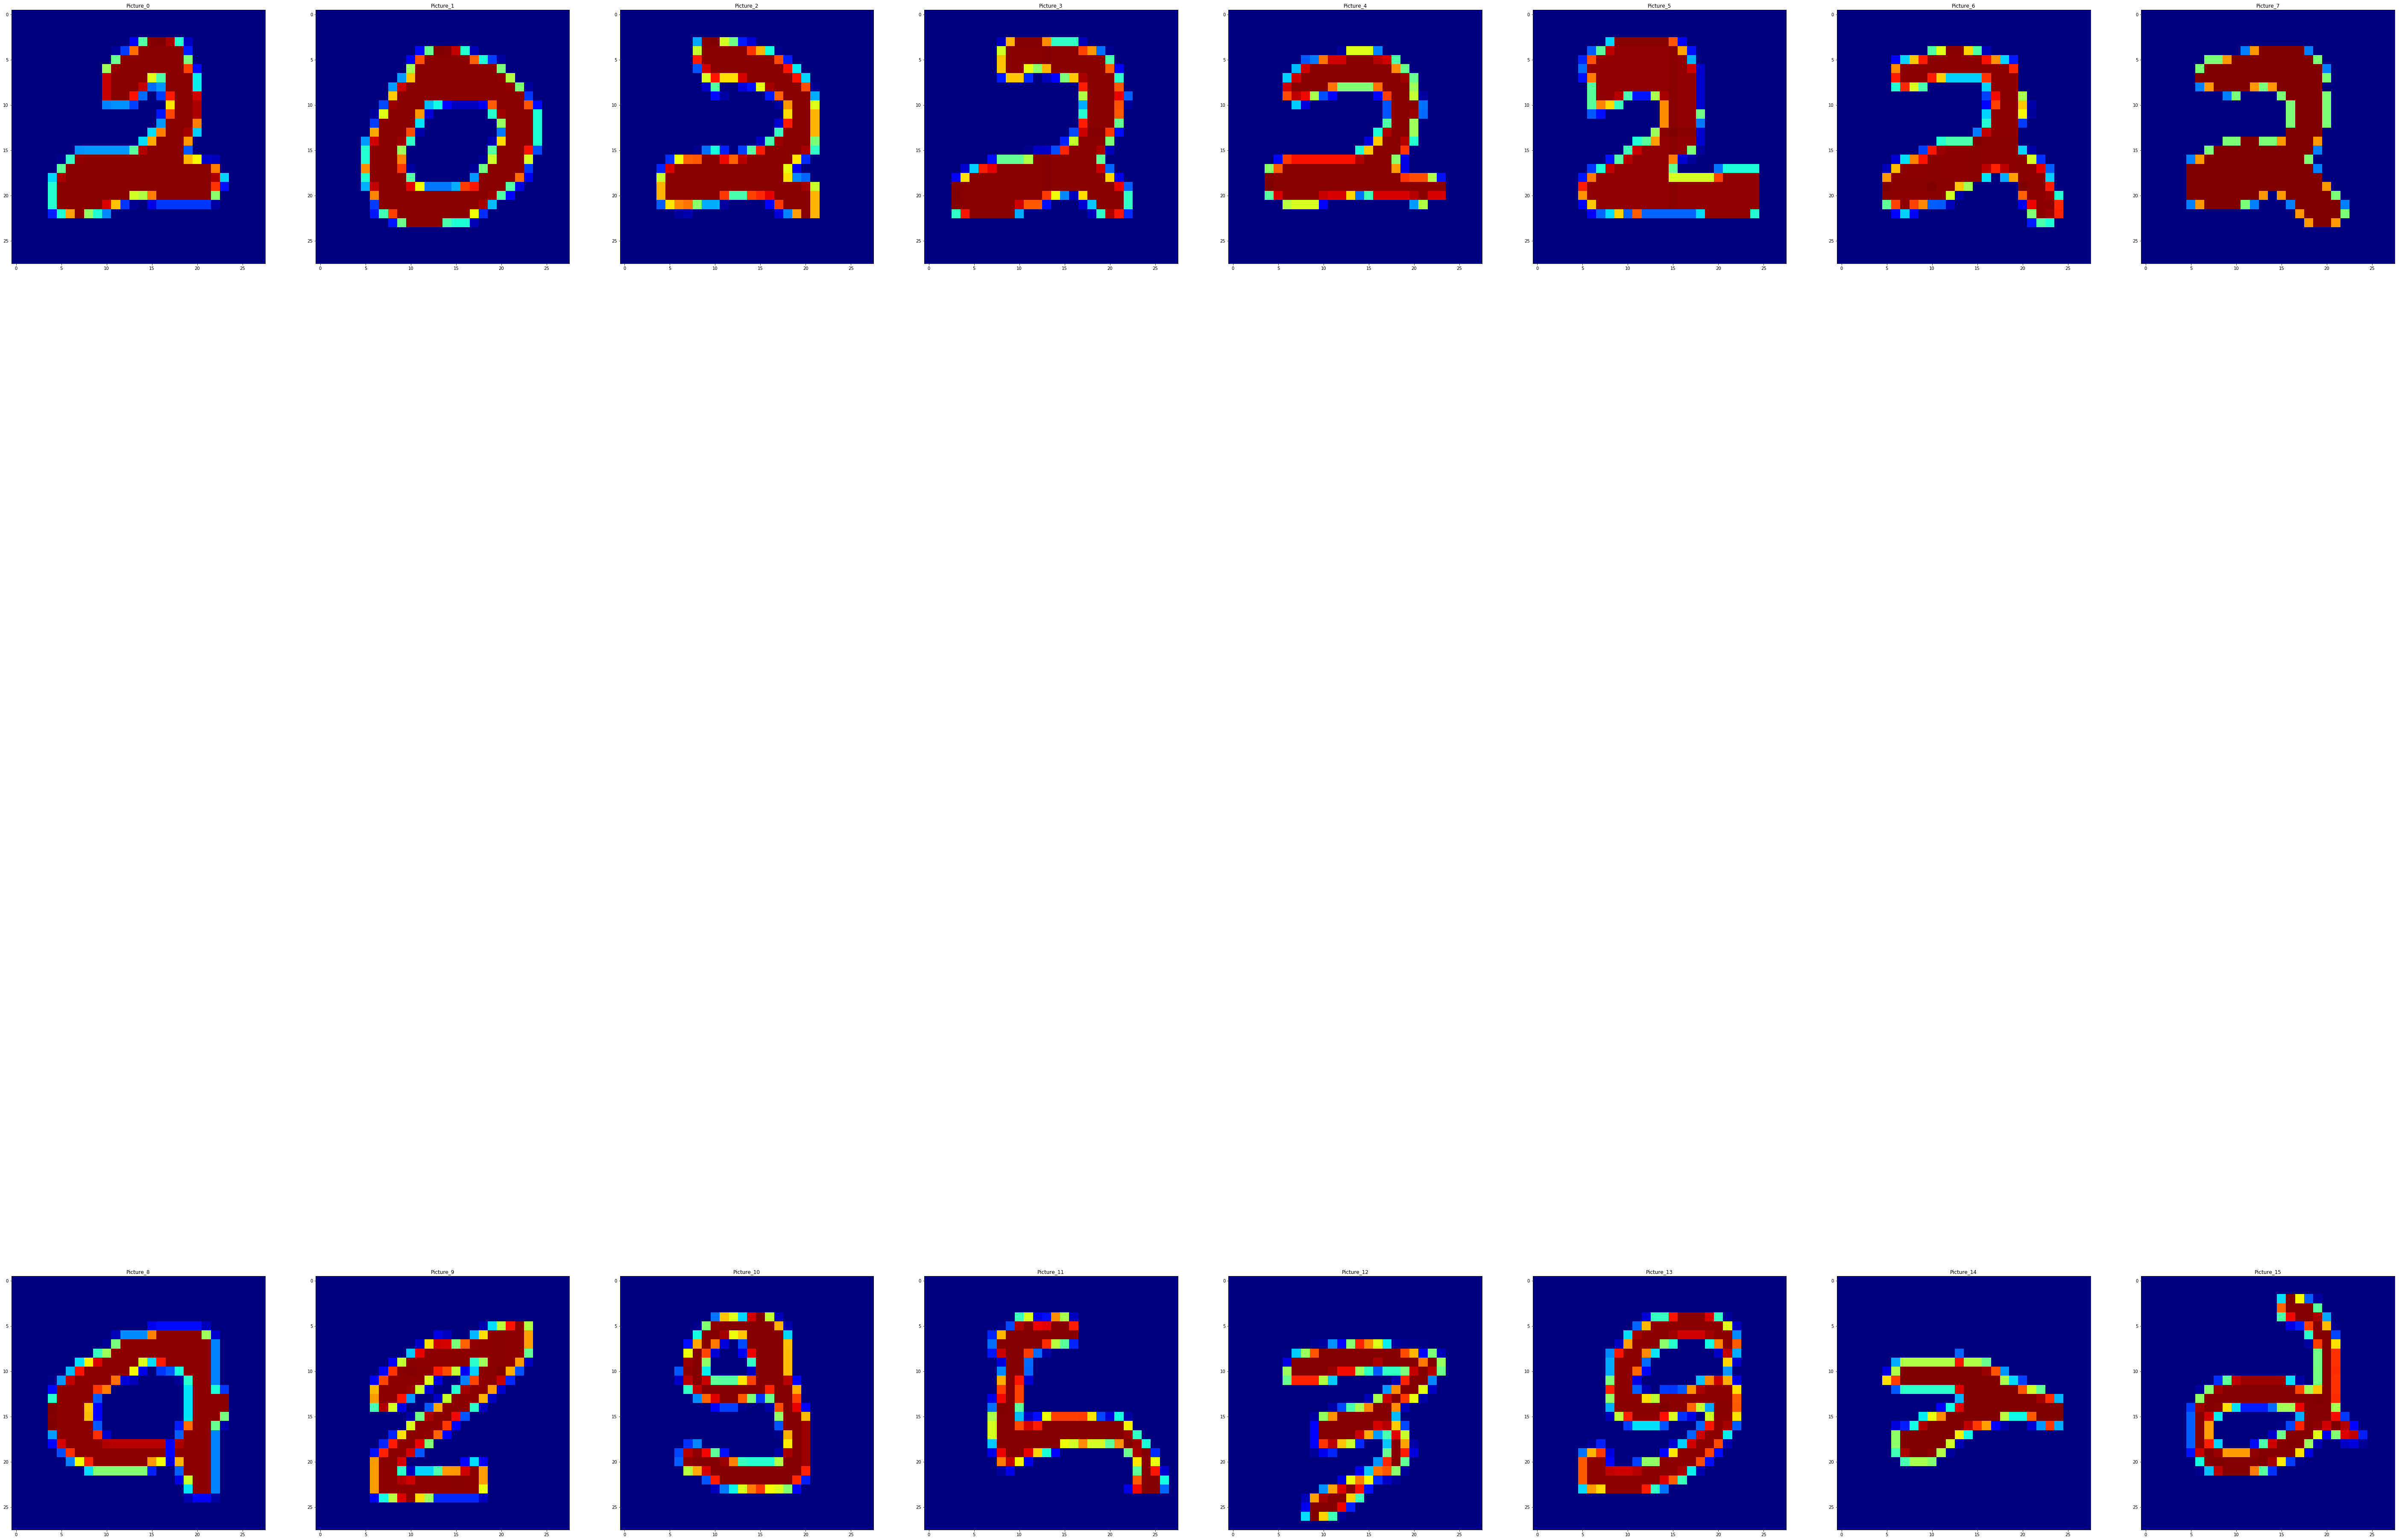

In [95]:
# YOUR CODE HERE
_, good_predictions = validate(x_valid, t_valid, w, b, top=8)
_, bad_predictions = validate(x_valid, t_valid, w, b, top=-8)

f, ax = plt.subplots(2, 8, figsize=(100,100))
idx = 0
labels = ["Most", "Least"]
predictions = [good_predictions, bad_predictions]
for i in range(2):
    print(labels[i], "loglikelihood")
    for j in range(8):
        ax[i,j].imshow(np.reshape(predictions[i][j], [28,28]), interpolation = "none", cmap = "jet")
        ax[i,j].set_title( "Picture_" + str(idx))
        idx += 1
#     plt.show()

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

**As is seen in the results, the easy pictures look neater and the harder ones do look more chaotic. This is what makes a digit harder to classify; when it looks less like the other digits of its class in the dataset on which has been trained. This can be because their shap is off or because they have been moved out of the center**

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

$\nabla_{\bb} \mathcal{L}^{(n)}$ will be exactly the same because the only difference between the earlier case, is that now $\log q_j = \bw_j^T \bh + b_j$.
For this same reason $\nabla_{\bw_j} \mathcal{L}^{(n)}$ will only differ in that $x_i$ is now $h_i$.

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
=
1  - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 
1 - \frac{\exp(\log q_j)}{Z} 
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
=
- \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
=
- \frac{1}{Z} 
\frac{\partial Z}{\partial \log q_j}
&=
- \frac{\exp(\log q_j)}{Z} 
\end{align}

For $\delta^h$:

$$
\delta^h_j
=
\frac{\partial L^{(n)}}{\partial \textbf{h}_j }
=
\sum_k
\frac{\partial L^{(n)}}{\partial \log(q_k)} \frac{\partial \log(q_k)}{\partial \textbf{h}_j}
=
\sum_k
\delta^q_j
\frac{\partial (w_k^T\textbf{h}+\textbf{b}_k)}{\partial \textbf{h}_j}
=
\sum_k
\delta^q_j
w_k^T\mathbb{I}_j
=
\sum_k \delta_k^q w_{kj}
$$

For
$
\frac{\partial (\mathcal{L}^{(n)})}{\partial \mathbf{b}}
$:

$$
\frac{\partial (\mathcal{L}^{(n)})}{\partial \mathbf{b}}
=
\frac{\partial (\mathcal{L}^{(n)})}{\partial \log(q)}
\frac{\partial \log(q)}{\partial \mathbf{b}}
=
\delta_j^q \cdot 1
=
\delta_j^q
$$

For:
$
\frac{\partial (\mathcal{L}^{(n)})}{\partial \mathbf{w}_j}
$

$$
\frac{\partial (\mathcal{L}^{(n)})}{\partial \mathbf{w}_j}
=
\frac{\partial }{\partial \mathbf{w}_j} \log q_j - \frac{\partial }{\partial \mathbf{w}_j}\log Z
=
\frac{\partial }{\partial \mathbf{w}_j}( \bw_j^T \bh + b_j) - \frac{\partial }{\partial \mathbf{w}_j}(\sum_j q_j)
=
\delta_j^q \bh
$$

For
$
\frac{\partial (\mathcal{L}^{(n)})}{\partial \mathbf{W}}
$:

$$
\frac{\partial (\mathcal{L}^{(n)})}{\partial \mathbf{W}}
=
\frac{\partial }{\partial \mathbf{W}} \log q_j - \frac{\partial }{\partial \mathbf{W}}\log Z
=
\frac{\partial }{\partial \mathbf{W}}( \bw_j^T \bh + b_j) - \frac{\partial }{\partial \mathbf{W}}(\sum_j q_j)
=
\delta^q \bh
$$

For
$
\frac{\partial (\mathcal{L}^{(n)})}{\partial  \textbf{a}}
$:

$$
\frac{\partial (\mathcal{L}^{(n)})}{\partial  \textbf{a}_j}
=
\frac{\partial (\mathcal{L}^{(n)})}{\partial h}
\frac{\partial h}{\partial  \textbf{a}_j}
=
\delta^h
\frac{\partial}{\partial  \textbf{a}_j} \sigma(\bv_j^T \bx + \textbf{a}_j)
=
\delta^h
\sigma(\bv_j^T \bx + a_j)(1-\sigma(\bv_j^T \bx + a_j))\frac{\partial}{\partial  \textbf{a}_j}( \bv_j^T \bx + a_j)
=
\delta^h
h(1-h)
\frac{\partial a_j}{\partial \textbf{a}_j}
=
\delta^h
h(1-h)
$$

For
$
\frac{\partial (\mathcal{L}^{(n)})}{\partial  \textbf{V}}
$:

$$
\frac{\partial (\mathcal{L}^{(n)})}{\partial  \textbf{v}_j}
=
\frac{\partial (\mathcal{L}^{(n)})}{\partial h}
\frac{\partial h}{\partial  \textbf{v}_j}
=
\mathbf{\delta}^h
\frac{\partial }{\partial  \textbf{v}_j}
\sigma(\bv_j^T \bx + a_j)
=
\mathbf{\delta}^h
\sigma(\bv_j^T \bx + a_j)(1-\sigma(\bv_j^T \bx + a_j))\frac{\partial}{\partial  \textbf{v}_j}( \bv_j^T \bx + a_j)
=
\mathbf{\delta}^h
h(1-h)
\frac{\partial ( \bv_j^T \bx)}{\partial  \textbf{v}_j}
=
\mathbf{\delta}^h
h(1-h)
\mathbf{x}^T
$$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

YOUR ANSWER HERE

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [65]:
from scipy.stats import logistic
from scipy.special import expit

def print_shapes(names,matrices):
    for name,matrix in zip(names,matrices):
        print("{} shape: {}".format(name,matrix.shape))
        
def get_delta_q(log_q, log_Z, b, t, log_p):
#     delta_q2 = -np.exp(log_q)/np.exp(log_Z)
    delta_q4 = -np.exp(log_p)
    
    delta_q4[0,t] += 1,
   
    return delta_q4.T

def get_Z(log_q):
    a = np.ndarray.max(log_q)
    log_Z = a
    log_Z += np.log(sum(np.exp(log_q-a)))
    
    return log_Z
        
def forward_pass(x, w, b, v, a):
    # Compute f 
#     f = np.dot(x,v)+a.T
    f = np.add(np.dot(x,v),a.T)
    
    #Compute h
    h = expit(f)
    
    # Compute log(q) 
    log_q = np.add(np.dot(h,w),b)
    
    # Compute Z, keeping it numerically stable
    log_Z = get_Z(log_q)
    
    # Compute log(p) (softmax)
    logp = np.subtract(log_q, log_Z)
    
    return logp,log_q, log_Z, h

def back_propagate(logp, log_q, log_Z, h, t, w, b, x):
    # Compute delta_q
    delta_q = get_delta_q(log_q, log_Z, b, t, logp)
    
    # Compute delta_h
    delta_h = np.dot(w,delta_q).reshape(20,1)
    
    # Compute gradients w.r.t w,b,a,v
    dL_db = delta_q
    dL_dw = np.dot(h.T,delta_q.reshape(1,10))
    dL_da = delta_h.T.dot(h.T.dot(1-h))
    dL_dv = delta_h*h.dot(1-h.T).dot(x)
    
    return dL_db, dL_dw, dL_da, dL_dv

# Write all helper functions here
def logreg_gradient_ML(x, t, w, b, v, a):
    
    # do the forward pass
    logp, log_q, log_Z, h = forward_pass(x, w, b, v, a)
    
    # find derivatives
    dL_db, dL_dw, dL_da, dL_dv = back_propagate(logp, log_q, log_Z, h, t, w, b, x)

    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze(),dL_da,dL_dv.T

def validate_ML(x_valid, t_valid, w, b, V,a, top=0):
    
    indices = np.array(range(len(x_valid)))    
    logp_list = []
    for index in indices:
        
        # we only need the forward pass for validation
        forwardly_passed, _, _, _ = forward_pass(x_valid[index:index+1,:], w, b, V, a)
        logp_train = forwardly_passed[:,t_valid[index]].squeeze()
        logp_list.append(logp_train)
        
    show = None
    
    if (not top == 0):
    
        maxx = np.array(logp_list).argsort()

        if top>=0:
            show = x_valid[maxx[len(maxx)-1-top:]]
        else:
            show = x_valid[maxx[0:-top]]

    return np.mean(logp_list), show

def weight_updates(W, b, V, a, grad_w, grad_b,dL_da, dL_dv ):
    W = np.add(W, np.dot(eta, grad_w))
    b = np.add(b, np.dot(eta, grad_b))
    V = np.add(V, np.dot(eta, dL_dv))
    a = np.add(a, np.dot(eta, dL_da.T))
    return W, b, V, a
    

def sgd_iter_ML(x_train, t_train, W, b, V, a , eta = 1e-4):
    indices = np.array(range(len(x_train)))
    np.random.shuffle(indices)

    logp_list = []
    for index in indices:
        _, grad_w, grad_b,dL_da, dL_dv = logreg_gradient_ML(
            x_train[index:index+1,:],
            t_train[index:index+1],
            W,
            b,
            V,
            a
        )
        W, b, V, a = weight_updates(W, b, V, a, grad_w, grad_b, dL_da, dL_dv )
        
    mean_log_p, _ = validate_ML(x_train, t_train, W, b, V,a)
        
    return mean_log_p, W, b,V,a

def test_sgd_ML(x_train, t_train, x_valid, t_valid, w, b, V, a, eta):
    epsilon = 0.005
    diff = sys.maxsize
    diff_valid = sys.maxsize
    logp = [diff]
    logp_v = [diff_valid]
    for i in range(30):
        logp_train, w, b,V,a = sgd_iter_ML(x_train, t_train, w, b, V, a, eta=eta)
        logp_valid, _ = validate_ML(x_valid, t_valid, w, b, V, a)
        
        diff = abs(sum(logp_train - logp[-1]))
        
        logp.append(logp_train)
        logp_v.append(logp_valid)
        
        print("epoch:", i, "difference with last epoch:", diff, "current average log likelihood:", logp_train )
        
    
    logp.pop(0)
    logp_v.pop(0)
    
    
    return w,b,V,a, logp, logp_v


Eta 0.01
epoch: 0 differnce with last epoch: 9.223372036854776e+18 current average log likelihood: -0.45880215680497677
epoch: 1 differnce with last epoch: 0.04736142356720935 current average log likelihood: -0.4114407332377674
epoch: 2 differnce with last epoch: 0.018507782114137172 current average log likelihood: -0.39293295112363025
epoch: 3 differnce with last epoch: 0.006552230562260508 current average log likelihood: -0.38638072056136974
epoch: 4 differnce with last epoch: 0.009220830246902123 current average log likelihood: -0.3771598903144676
epoch: 5 differnce with last epoch: 0.002714487870288662 current average log likelihood: -0.37444540244417895
epoch: 6 differnce with last epoch: 0.0020693789970631093 current average log likelihood: -0.37651478144124206
epoch: 7 differnce with last epoch: 0.011725174173439157 current average log likelihood: -0.3882399556146812
epoch: 8 differnce with last epoch: 0.00916939054794691 current average log likelihood: -0.39740934616262813
epoc

epoch: 15 differnce with last epoch: 0.004939476315341529 current average log likelihood: -0.4551030855260088
epoch: 16 differnce with last epoch: 0.004644270505534176 current average log likelihood: -0.45045881502047463
epoch: 17 differnce with last epoch: 0.003804911029848146 current average log likelihood: -0.4466539039906265
epoch: 18 differnce with last epoch: 0.0028805526123495406 current average log likelihood: -0.44377335137827695
epoch: 19 differnce with last epoch: 0.004503869235901237 current average log likelihood: -0.4392694821423757
epoch: 20 differnce with last epoch: 0.0032529601837354982 current average log likelihood: -0.4360165219586402
epoch: 21 differnce with last epoch: 0.0034551343404828905 current average log likelihood: -0.4325613876181573
epoch: 22 differnce with last epoch: 0.0021409143423329335 current average log likelihood: -0.4304204732758244
epoch: 23 differnce with last epoch: 0.002174785398053991 current average log likelihood: -0.4282456878777704
epoc

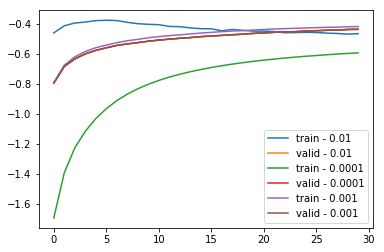

         200895234 function calls (200890628 primitive calls) in 1369.371 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       11    0.000    0.000 1369.370  124.488 /home/stijnverdenius/miniconda3/envs/ml1labs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3228(run_code)
       11    0.000    0.000 1369.370  124.488 {built-in method builtins.exec}
        1    0.000    0.000 1369.106 1369.106 <ipython-input-66-723c399d4e8d>:14(<module>)
        3    0.336    0.112 1369.102  456.367 <ipython-input-65-b87d8a8db9ff>:122(test_sgd_ML)
       90   43.209    0.480 1314.056   14.601 <ipython-input-65-b87d8a8db9ff>:102(sgd_iter_ML)
  4500000   35.332    0.000  730.990    0.000 <ipython-input-65-b87d8a8db9ff>:60(logreg_gradient_ML)
  9900000  110.852    0.000  668.965    0.000 <ipython-input-65-b87d8a8db9ff>:23(forward_pass)
 46801037  467.774    0.000  467.774    0.000 {built-in method numpy.core.multiarray.dot}
 

In [66]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()

w,b,a,V = None,None,None,None

# Shown tests for testing
np.random.seed(123)
hidden_dim = 20

logp_vs = []
logps = []
etas = [1e-2, 1e-4, 1e-3 ]
for eta in etas:
    print("Eta {}".format(eta))
    w = np.random.normal(size=(hidden_dim,10), scale=0.1)
    b = np.zeros((10,))

    a = np.zeros((1, hidden_dim)).T
    V = np.random.normal(size=(784, hidden_dim), scale=0.1)

    w,b,V,a,logp, logp_v = test_sgd_ML(x_train, t_train, x_valid, t_valid, w, b, V, a, eta)
    
    logps.append(logp)
    logp_vs.append(logp_v)
    
for logp, logpv, eta in zip(logps, logp_vs, etas):
    plt.plot(logp, label="train - {}".format(eta))
    plt.plot(logp_v, label="valid - {}".format(eta))
    
plt.legend()
plt.show()

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print (s.getvalue())


In [ ]:
# Hidden tests for efficiency

In [ ]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

# 

# YOUR CODE HERE
raise NotImplementedError()

V shape: (784, 20)
W shape: (20, 10)


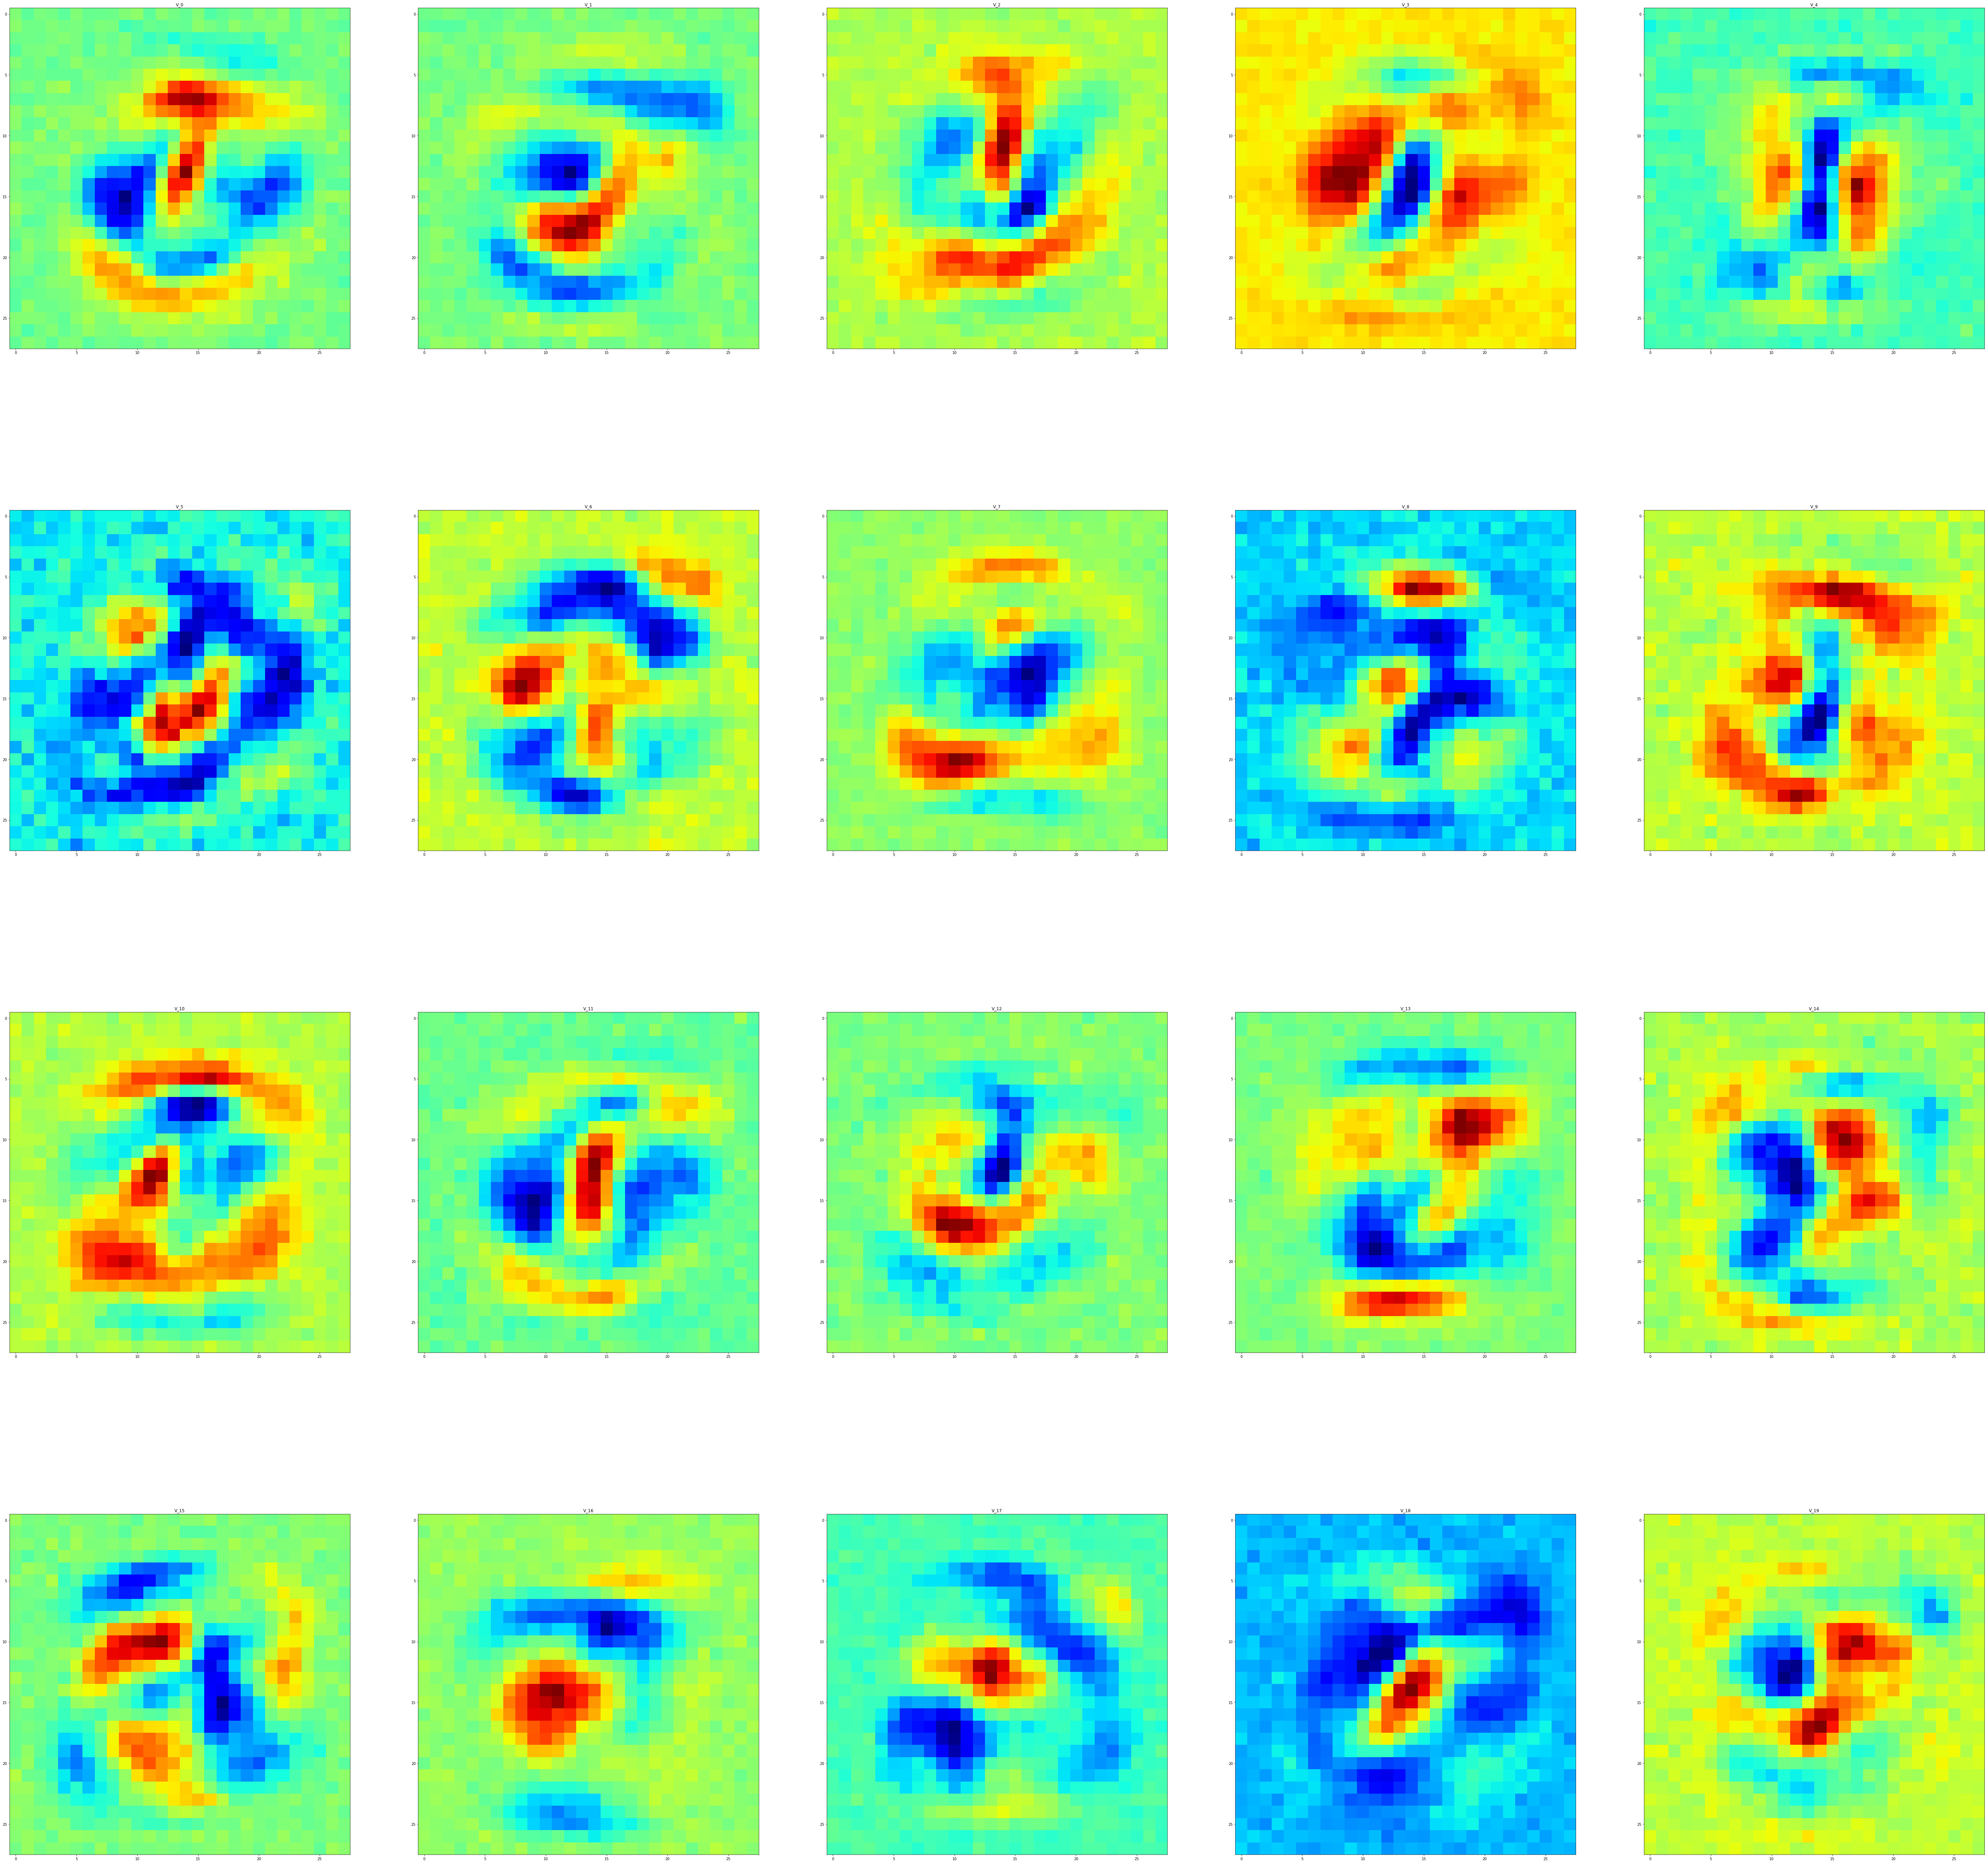

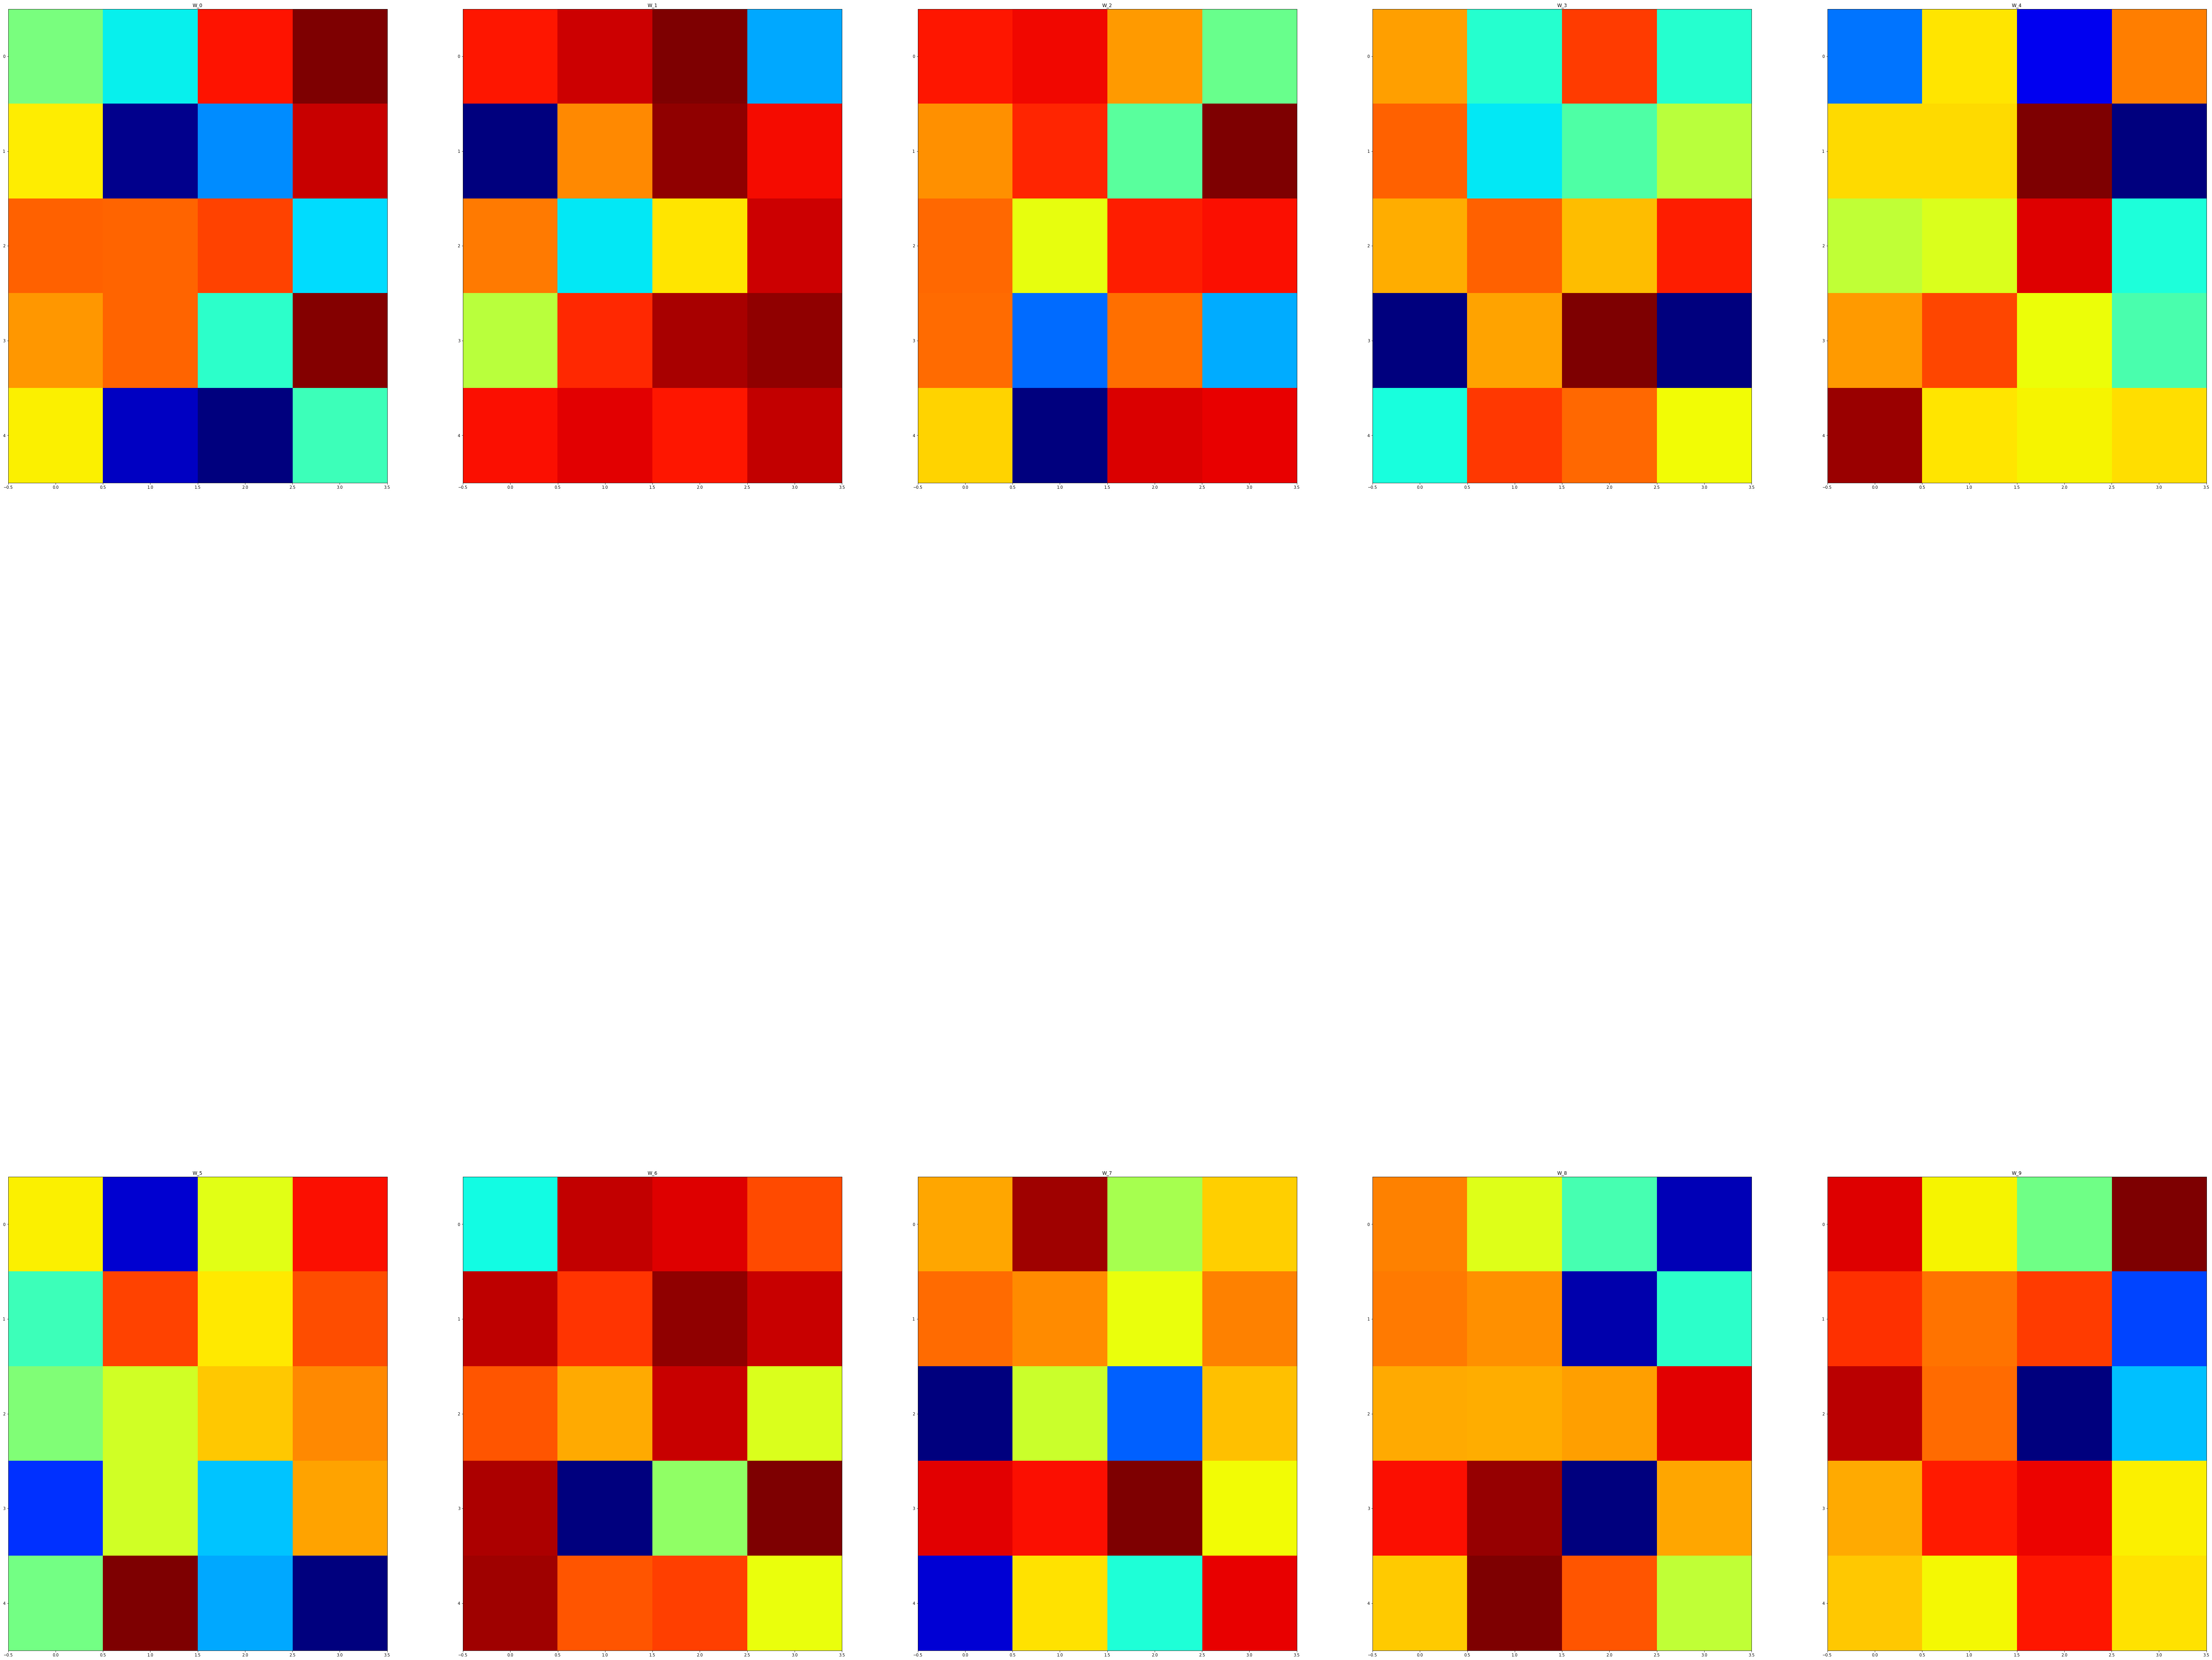

In [60]:
# plot the train and validation logp for all three learning rates in one figure
# YOUR CODE HERE
print_shapes(["V", "W"], [V,w])  

print("Weights visualize of V (first layer)")

f, ax = plt.subplots(4, 5, figsize=(100,100))
idx = 0
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(np.reshape(V[:, idx], [28,28]), interpolation = "none", cmap = "jet")
        ax[i,j].set_title( "V_" + str(idx))
        idx += 1
plt.show()

print("Weights visualize of W (second layer)")

f, ax = plt.subplots(2, 5, figsize=(100,100))
idx = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(np.reshape(w[:, idx], [5,4]), interpolation = "none", cmap = "jet")
        ax[i,j].set_title( "W_" + str(idx))
        idx += 1
        
plt.show()

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

**In the case of 1e-2 we see that the likelihood increases really fast at first but then it also gets woirse again. This can be explained by a too high learning rate to descent into a local minimum and thus the algorithm keeps oscillating around that minimum. However, with learning rate of 1e-4 we get convergence but too slowly. In the end the run with 1e-3 is the best because its fast but it does not get stuck in oscillation.**

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

In [ ]:
# done up there

**Observed in the weights of the first layer is that more low-level features are extracted from the pictures. Such as arches, circles or edges. These features are thus learned and the classification in this lower dimensional space can then be learned in the second layer. This is also why the network outperforms the logistic regression classifier. It is a more flexible model and does some of the feature engineering for you where before we just took raw pixel value as features.**

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

ReLU:
$$
\frac{\partial}{\partial x}ReLU(x)
=
\frac{\partial}{\partial x}
\left\{\begin{matrix}
0 & x \leq 0 \\ 
x & x > 0
\end{matrix}\right.
=
\left\{\begin{matrix}
0 & x < 0 \\ 
1 & x > 0
\end{matrix}\right.
$$

TanH:
$$
\frac{\partial}{\partial x}tanh(x)
=
\frac{\partial}{\partial x}
\frac{e^x + e^{-x}}{e^x - e^{-x}}
=
\frac{\partial}{\partial x}
\frac{e^x-e^{-x}(e^x - e^{-x})-(e^x + e^{-x})(e^x + e^{-x})}{(e^x - e^{-x})^2}
=
\frac{e^x-e^{-x}(e^x - e^{-x})}{(e^x - e^{-x})^2}
-
\frac{(e^x + e^{-x})(e^x + e^{-x})}{(e^x - e^{-x})^2}
=
\frac{e^x-e^{-x}}{e^x - e^{-x}}
-
tahn(x)^2
=
1
-
tanh(x)^2
$$

Sigmoid:
$$
\frac{\partial}{\partial x}\sigma(x)
=
\sigma(x)(\sigma(x)-1)
$$


Name two properties that you would like your activation function to have (one sentence each). Why are they important?


**- The activation must have an easy derivative on which can be applied multiple layers in of the chain rule without it getting too complicated or information being lost**

**- Computationally undemanding for fast forward passes in the network**


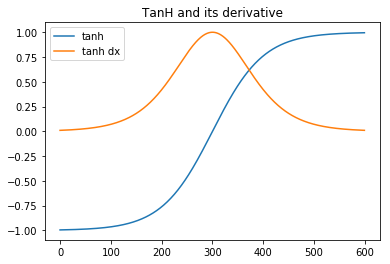

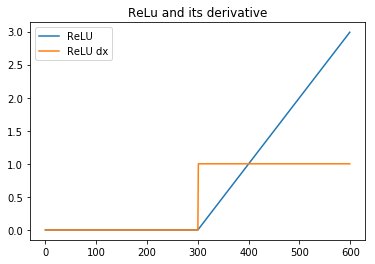

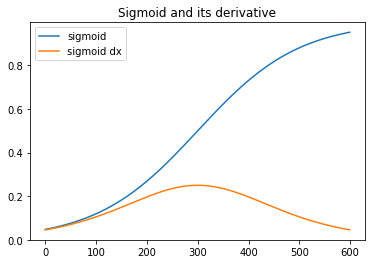

In [62]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def relu_dx(x):
    if x > 0:
        return 1
    else:
        return 0
    
def maximum(x):
    return max(0,x)

def sigmoid_dx(x):
    return sigmoid(x)*(1-sigmoid(x))

# YOUR CODE HERE
x = np.arange(-3,3,0.01)

plt.title("TanH and its derivative")
plt.plot(np.tanh(x), label="tanh")
plt.plot(1-np.tanh(x)**2, label ="tanh dx")
plt.legend()
plt.show()

plt.title("ReLu and its derivative")
plt.plot(np.maximum(x, 0), label="ReLU")
plt.plot(np.array(list(map(relu_dx, x))),label ="ReLU dx")
plt.legend()
plt.show()

plt.title("Sigmoid and its derivative")
plt.plot(np.array(list(map(sigmoid, x))), label="sigmoid")
plt.plot(np.array(list(map(sigmoid_dx, x))), label="sigmoid dx")
plt.legend()
plt.show()



Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

**Although all three have their own nice property, we are going with ReRu, because its derivative is easy to compute and also the application of the activation function is easy. In the neural network that we implemented in the excersise we found that applying the sigmoid activation function was a bottleneck in time performance. Dispite sigmoid having an nice derivative, also the derivative of ReLu is nice, having only ones and zeroes, making it possible to discard a lot without increasing computational complexity.**

In [ ]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))